## Import necessary libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [36]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,GRU,Dropout,Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint #This line imports a special tool from Keras called ModelCheckpoint,ModelCheckpoint is a callback function that allows you to save your model automatically while it's training.

In [24]:
df=pd.read_csv("ocean wave prediction with LSTM.csv")
df.head()

,Date/Time,Hs,Hmax,Tz,Tp,Peak Direction,SST
0,01-01-17 0:00,-99.900,-99.90,-99.900,-99.900,-99.9,-99.90
1,01-01-17 0:30,0.875,1.39,4.421,4.506,-99.9,-99.90
2,01-01-17 1:00,0.763,1.15,4.520,5.513,49.0,25.65
3,01-01-17 1:30,0.770,1.41,4.582,5.647,75.0,25.50
4,01-01-17 2:00,0.747,1.16,4.515,5.083,91.0,25.45


In [26]:
# Deleting NAN values
df.replace(-99.90,np.nan,inplace=True)
df.drop('Date/Time',axis=1,inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df.head()

,Hs,Hmax,Tz,Tp,Peak Direction,SST
0,0.763,1.15,4.520,5.513,49.0,25.65
1,0.770,1.41,4.582,5.647,75.0,25.50
2,0.747,1.16,4.515,5.083,91.0,25.45
3,0.718,1.61,4.614,6.181,68.0,25.45
4,0.707,1.34,4.568,4.705,73.0,25.50


## Visualization of features


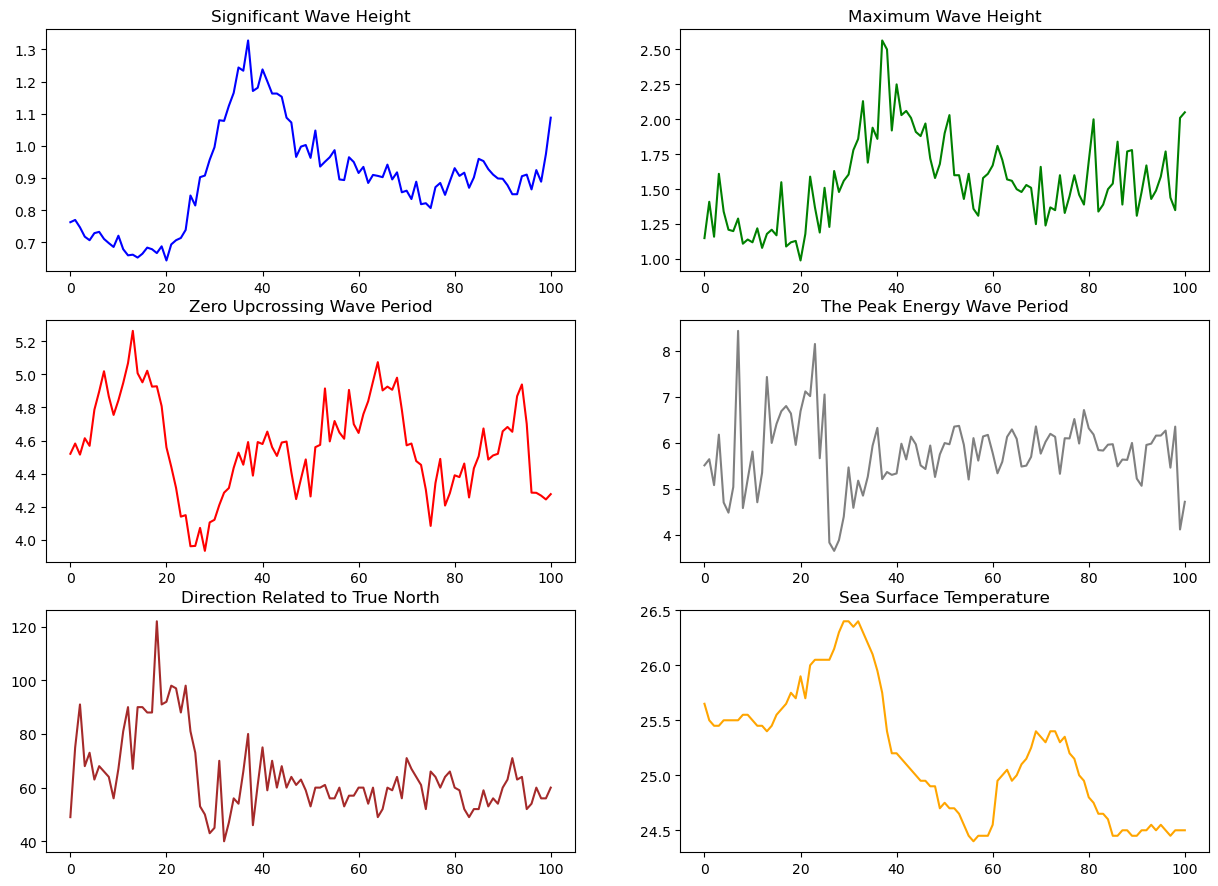

In [28]:
df_graph=df.loc[0:100]
plt.figure(figsize=(15,22))
plt.subplot(6,2,1)
plt.plot(df_graph['Hs'],color='blue')
plt.title('Significant Wave Height')

plt.subplot(6,2,2)
plt.plot(df_graph['Hmax'],color='green')
plt.title('Maximum Wave Height')

plt.subplot(6,2,3)
plt.plot(df_graph['Tz'],color='red')
plt.title('Zero Upcrossing Wave Period')

plt.subplot(6,2,4)
plt.plot(df_graph['Tp'],color='grey')
plt.title('The Peak Energy Wave Period')

plt.subplot(6,2,5)
plt.plot(df_graph['Peak Direction'],color='brown')
plt.title('Direction Related to True North')

plt.subplot(6,2,6)
plt.plot(df_graph['SST'],color='orange')
plt.title('Sea Surface Temperature')
plt.show()




## Initial statistics

In [30]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43454 entries, 0 to 43453
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Hs              43454 non-null  float64
 1   Hmax            43454 non-null  float64
 2   Tz              43454 non-null  float64
 3   Tp              43454 non-null  float64
 4   Peak Direction  43454 non-null  float64
 5   SST             43454 non-null  float64
dtypes: float64(6)
memory usage: 2.0 MB
None


In [307]:
df.describe()

,Hs,Hmax,Tz,Tp,Peak Direction,SST
count,43454.000000,43454.000000,43454.000000,43454.000000,43454.000000,43454.000000
mean,1.237799,2.090125,5.619685,9.011972,98.626594,23.949641
std,0.528608,0.897640,0.928533,2.390107,24.275165,2.231022
min,0.294000,0.510000,3.076000,2.720000,5.000000,19.800000
25%,0.839000,1.410000,4.981000,7.292000,85.000000,21.900000
50%,1.130000,1.900000,5.530000,8.886000,101.000000,23.950000
75%,1.544000,2.600000,6.166000,10.677000,116.000000,26.050000
max,4.257000,7.906000,10.921000,21.121000,358.000000,28.650000


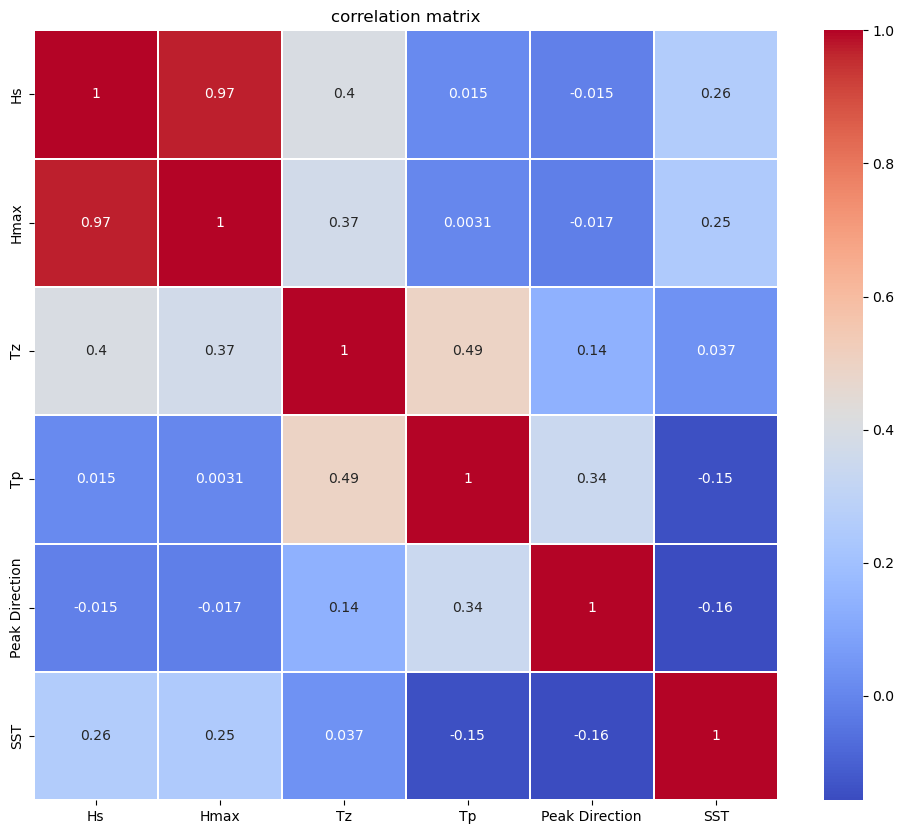

In [32]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),linewidth=.2,annot=True,cmap="coolwarm")
plt.title("correlation matrix")
plt.show()

## Feature Scaling

In [38]:
# Scaling all the value between 0 t0 1
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(df)
print('Shape of the scaled data matrix: ', data.shape)

Shape of the scaled data matrix:  (43454, 6)


## Train & Test split

In [40]:
# Seperate the data into 2 groups i.e. Train & Test
train = data[:42000,]
test = data[42000: ,]

# Shapes of our datasets
print('Shape of train data: ', train.shape)
print('Shape of test data: ', test.shape)

Shape of train data:  (42000, 6)
Shape of test data:  (1454, 6)


In [42]:
#prepares sequences of 40 samples to be used as inputs, and the next (41) sample as the output. This is commonly used in time series or sequence prediction problems
def prepare_data(data):
    databatch = 40 # This is the number of past samples to use as input
    x_list = [] # To store input sequences
    y_list = [] #To store output values
#Loop Explanation:The function prepare_data(data) prepares sequences of 40 samples to be used as inputs, and the next (41st) sample as the output. This is commonly used in time series or sequence prediction problems    
    for i in range(len(data)-databatch-1):
        x_list.append(data[i:i+databatch]) # Take 40 rows as input,data[i:i+40] = 40 rows → input
        y_list.append(data[i+databatch+1]) # Take the 41st row as output,data[i+40+1] = 1 row → output
#Reshape for Model Input       
    X_data = np.array(x_list)
    X_data = np.reshape(X_data, (X_data.shape[0], X_data.shape[2], X_data.shape[1])) #X_data.shape[0] = number of sequences,X_data.shape[2] = number of features (columns in original data),X_data.shape[1] = 30 (number of time steps),So after reshaping, the input becomes in this shape:(number of sequences, features, time steps)which is useful for models like RNN, LSTM, etc.,
    y_data = np.array(y_list) #Convert the output list to a NumPy array.
#Return Values    
    return X_data, y_data #X_data: all input sequences (40 samples each),y_data: corresponding target outputs (41 sample)


                  


In [44]:
# Executing the separation
X_train,y_train=prepare_data(train)
X_test,y_test=prepare_data(test)
print('X_train Shape :',X_train.shape, 'y_train shape :', y_train.shape)
print('X_test Shape  : ', X_test.shape, ' y_test shape  :', y_test.shape)

X_train Shape : (41959, 6, 40) y_train shape : (41959, 6)
X_test Shape  :  (1413, 6, 40)  y_test shape  : (1413, 6)


## creating the LSTM model

In [46]:
def lstm_model(x_data, y_data, num_epochs, batch_size, learning_rate):
    # Creating the model
    model = Sequential()
    # Adding the first layer
    model.add(LSTM(32, input_shape=(x_data.shape[1], x_data.shape[2]), return_sequences=True))
    # Adding the second layer 
    model.add(LSTM(16, return_sequences=True))
    # Adding a dropout value in order to prevent overfiting
    model.add(Dropout(0.2))
    # Adding the third layer
    model.add(LSTM(10))
    # Adding the output layer. 6 nodes are selected because the data has 6 features
    model.add(Dense(6))
    
    # Choosing the optimizer
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compiling the model
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])
    
    # Fitting the model
    history = model.fit(x_data, y_data, validation_split=0.25, epochs=num_epochs, batch_size=batch_size)
    
    return model, history

In [48]:
history = lstm_model(X_train, y_train, num_epochs=20, batch_size=200, learning_rate=.001)

C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0491 - mean_squared_error: 0.0491 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 6/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 7/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_los

## Visulaization of the learning

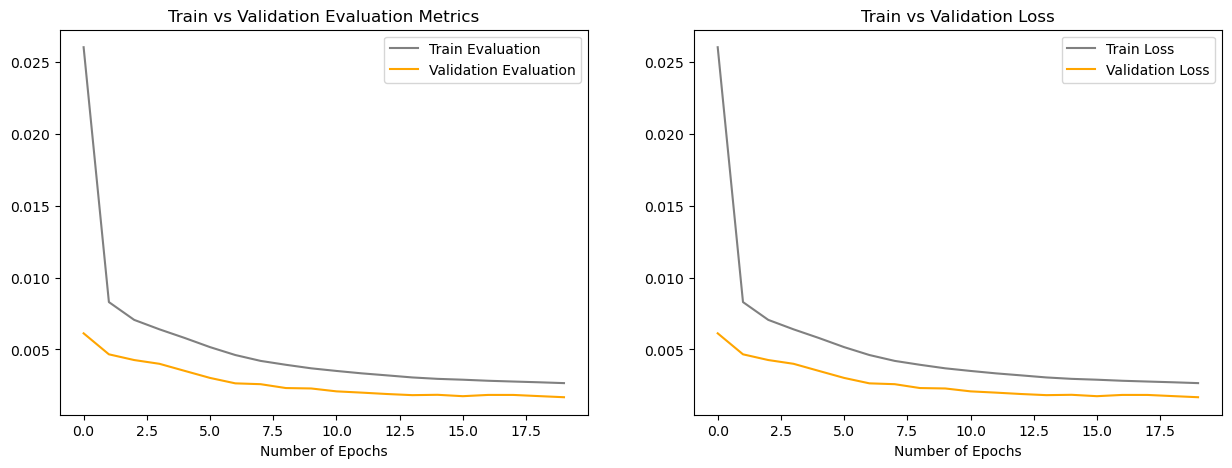

In [50]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(history[1].history['mean_squared_error'], color='grey', label='Train Evaluation')
plt.plot(history[1].history['val_mean_squared_error'], color='orange', label='Validation Evaluation')
plt.title('Train vs Validation Evaluation Metrics')
plt.xlabel('Number of Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history[1].history['loss'], color='grey', label='Train Loss')
plt.plot(history[1].history['val_loss'], color='orange', label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Number of Epochs')
plt.legend()
plt.show()
 

## Predictions

In [52]:
# Defining function to predict datas
def predicting(data, y_real):
    predicted_data = history[0].predict(data)
    # Invert scaling process to get the normal values range for the features 
    predicted_data = scaler.inverse_transform(predicted_data)
    #Inverse Transform
    y_real = scaler.inverse_transform(y_real)
    
    return predicted_data, y_real

In [54]:
## Execution of predictions
train_prediction,y_train=predicting(X_train,y_train)
test_prediction,y_test=predicting(X_test,y_test)

1312/1312 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


## Evaluating the Model success

In [56]:
# Defining function to investigate the root of mean squared errors (RMSE) between predicted and real data
import math
from sklearn.metrics import mean_squared_error

def examine_rmse(y_data, predicted_data):
    feature_names = ['Hs', 'Hmax', 'Tz', 'Tp', 'Direction', 'SST']
    
    for i, feature in enumerate(feature_names):
        rmse = math.sqrt(mean_squared_error(y_data[:, i], predicted_data[:, i]))
        print(f'RMSE_{feature:10}: {rmse:.4f}')

   

## Execute the rmse comparision 

In [59]:
# Executing the RMSE comparison
print('Trainin Data Errors')
print(examine_rmse(y_train, train_prediction),'\n')
print('Test Data Errors')
print(examine_rmse(y_test, test_prediction))
      

Trainin Data Errors
RMSE_Hs        : 0.1121
RMSE_Hmax      : 0.2762
RMSE_Tz        : 0.3359
RMSE_Tp        : 1.3325
RMSE_Direction : 15.2015
RMSE_SST       : 0.2907
None 

Test Data Errors
RMSE_Hs        : 0.1103
RMSE_Hmax      : 0.2700
RMSE_Tz        : 0.3478
RMSE_Tp        : 1.9763
RMSE_Direction : 14.8048
RMSE_SST       : 0.3453
None


## Visualization of the Real and Predicted Values

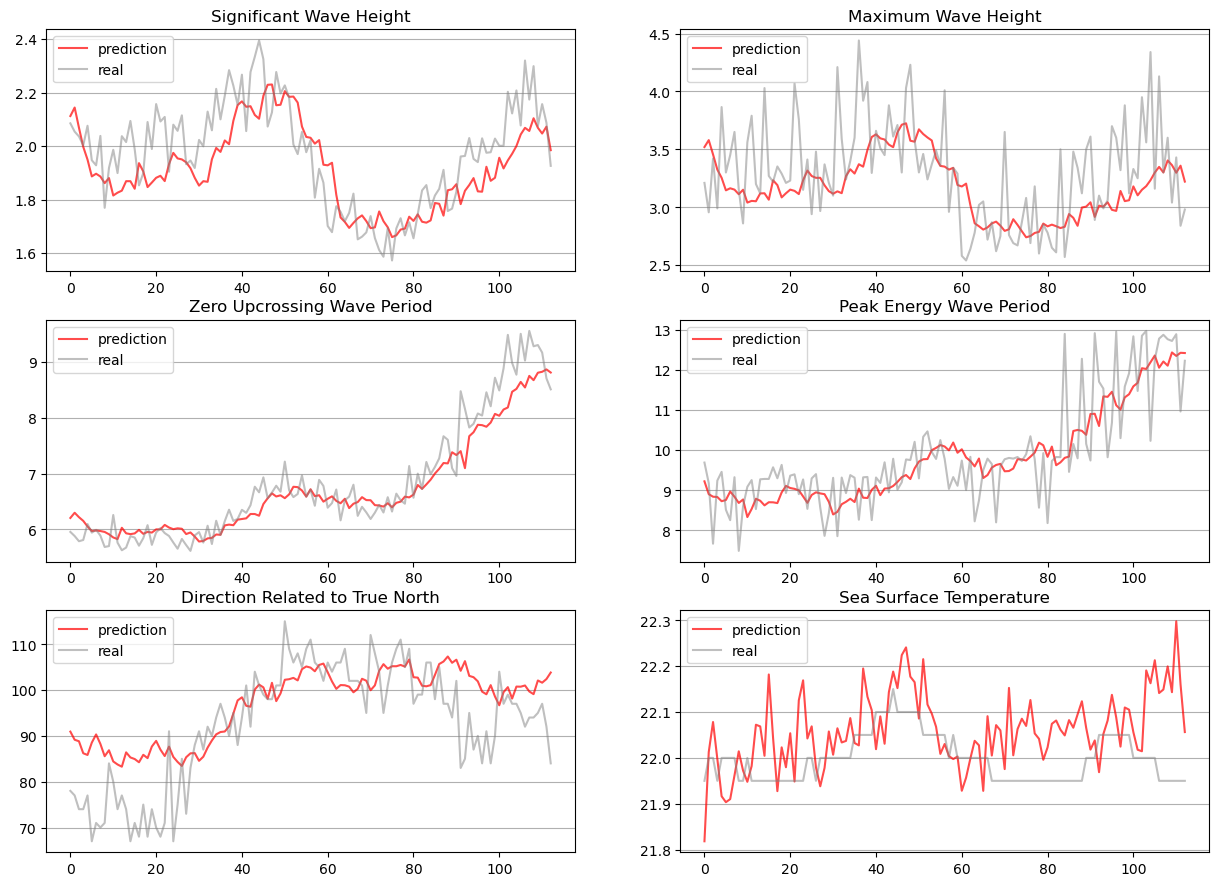

In [72]:
titles = [
    'Significant Wave Height',
    'Maximum Wave Height',
    'Zero Upcrossing Wave Period',
    'Peak Energy Wave Period',
    'Direction Related to True North',
    'Sea Surface Temperature'
]

plt.figure(figsize=(15,22))

for i in range(6):
    plt.subplot(6, 2, i+1)
    plt.plot(test_prediction[1300:, i], color='red', alpha=0.7, label='prediction')
    plt.plot(y_test[1300:, i], color='grey', alpha=0.5, label='real')
    plt.title(titles[i])
    plt.legend()
    plt.grid(True, axis='y')

plt.show()

## The LSTM model predicts future values by analyzing a fixed sequence of previous data points. In this case, it uses 40 consecutive samples to forecast the (41 sample).

